# Feedforward Neural Network

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchsummary

### Hyper parameters

In [2]:
input_size = 784    # 28x28
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

### Load MNIST dataset

In [3]:
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor())

print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print("Number of mini batches", len(train_loader))

Number of mini batches 600


In [5]:
samples, labels = next(iter(train_loader))
print("input shape : ", samples.shape)
print("output shape : ", labels.shape)

input shape :  torch.Size([100, 1, 28, 28])
output shape :  torch.Size([100])


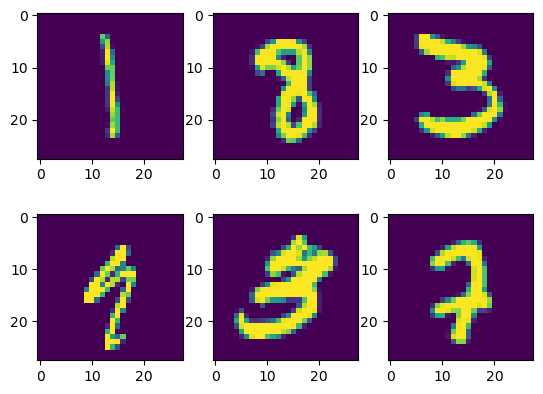

In [6]:
# Plot first 6 images of first batch

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i, 0])
plt.show()

In [7]:
labels

tensor([1, 8, 3, 9, 3, 7, 3, 1, 2, 1, 8, 0, 3, 6, 6, 6, 3, 4, 7, 0, 2, 9, 2, 8,
        3, 4, 9, 3, 4, 7, 4, 9, 2, 9, 3, 0, 8, 9, 8, 1, 9, 5, 7, 1, 8, 0, 8, 2,
        8, 7, 5, 3, 1, 1, 5, 4, 6, 4, 2, 7, 2, 7, 5, 5, 8, 7, 3, 7, 7, 9, 8, 9,
        9, 4, 9, 6, 4, 1, 9, 1, 3, 0, 2, 6, 0, 6, 0, 4, 2, 8, 5, 4, 4, 4, 0, 4,
        7, 6, 4, 3])

## Model

Softmax layer is not used. CrossEntropy Loss function uses an internal softmax when calculating losses

In [8]:
class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [9]:
model = NeuralNet(input_size, hidden_size, num_classes)

### Print Model Summary

In [10]:
torchsummary.summary(model, (1, input_size), device=torch.device("cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3                [-1, 1, 10]           1,010
         NeuralNet-4                [-1, 1, 10]               0
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------



(tensor(79510), tensor(79510))

### Generate ONN for plotting

In [11]:
input_names = ['MNIST Image']
output_names = ['Class']
x = torch.rand((input_size))
torch.onnx.export(model, x, './models/feed_forward.onnx', input_names=input_names, output_names=output_names)

## Loss and Optimizer

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [13]:
for epoch in range(num_epochs):
    for i, (samples, labels) in enumerate(train_loader):
        # reshape input
        samples = samples.reshape(-1, input_size)
        
        # forward pass
        outputs = model(samples)
        loss = loss_fn(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f"epoch = {epoch+1}, mini-batch = {i+1}, loss = {loss.item():.4f}")
    print(f"Epoch {epoch+1} Complete!")

epoch = 1, mini-batch = 100, loss = 0.4445
epoch = 1, mini-batch = 200, loss = 0.3545
epoch = 1, mini-batch = 300, loss = 0.3434
epoch = 1, mini-batch = 400, loss = 0.2382
epoch = 1, mini-batch = 500, loss = 0.2554
epoch = 1, mini-batch = 600, loss = 0.2083
Epoch 1 Complete!
epoch = 2, mini-batch = 100, loss = 0.2050
epoch = 2, mini-batch = 200, loss = 0.1865
epoch = 2, mini-batch = 300, loss = 0.0988
epoch = 2, mini-batch = 400, loss = 0.1389
epoch = 2, mini-batch = 500, loss = 0.2082
epoch = 2, mini-batch = 600, loss = 0.2160
Epoch 2 Complete!


In [14]:
print("shape of model output : ", outputs.shape)

shape of model output :  torch.Size([100, 10])


## Testing

In [15]:
with torch.no_grad():
    
    n_samples = 0
    n_correct = 0

    for samples, labels in train_loader:
        
        samples = samples.reshape(-1, input_size)

        outputs = model(samples)
        loss = loss_fn(outputs, labels)

        _, prediction = torch.max(outputs, 1)

        n_samples += outputs.shape[0]
        n_correct += (labels==prediction).sum().item()
    
    acc = 100.0 * n_correct / n_samples

    print(f'Accuracy = {acc:.2f}%')

Accuracy = 95.54%
